In [1]:
from qutip import create, destroy, qeye, basis, ket, mesolve, sigmam, sigmap, fidelity, tensor, fock_dm, sesolve,fock, sigmax, sigmaz, bell_state, sigmay
from qutip.solver import Options
from scipy.linalg import expm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
sns.set_palette(sns.color_palette('bright'))
#Useful constants 
rabi_0=2e5*np.pi #Hz
omega=2e6 #Hz
ldp=.1/np.sqrt(2)   
epsilon=2*ldp*rabi_0

n=10 #modes of motion
#Relevant Basis States 
g=basis(2,0)
e=basis(2,1)
gg=tensor(g, g, fock(n))   
ge=tensor(g, e, fock(n))
eg=tensor(e, g, fock(n))
ee=tensor(e,e, fock(n))

#Useful ops
sm=tensor(sigmam(),qeye(2))+tensor(qeye(2),sigmam())
sp=tensor(sigmap(),qeye(2))+tensor(qeye(2),sigmap())

$$H_{BSB}= \frac{i \eta}{2} (\Omega_b e^{i \delta_b t}S_{-}a- \Omega^{*}_b e^{-i \delta_b t}S_{+}a^{\dagger})$$
$$H_{RSB}= \frac{i \eta}{2} (\Omega_r e^{i \delta_r t}S_{-}a^{\dagger} - \Omega^{*}_r e^{-i \delta_r t}S_{+}a)$$

In [2]:

def H_MS(rabi_blue, rabi_red, blue_det, red_det):
    #Blue SB Hamiltonian terms
    H_BSB_i=(1j*ldp*rabi_blue/2)*tensor(sm,destroy(n))
    def H_BSB_TD_i(t, args):
        return np.exp(1j*(blue_det)*t)                 

    H_BSB_ii=(-1j*ldp*rabi_blue/2)*tensor(sp,create(n))
    def H_BSB_TD_ii(t, args):
        return np.exp(-1j*(blue_det)*t)

    #Red SB Hamiltonian terms
    H_RSB_i=(1j*ldp*rabi_red/2)*tensor(sm,create(n))
    def H_RSB_TD_i(t, args):
        return np.exp(1j*(red_det)*t)                 

    H_RSB_ii=(-1j*ldp*rabi_red/2)*tensor(sp,destroy(n))
    def H_RSB_TD_ii(t, args):
        return np.exp(-1j*(red_det)*t)

    #  Blue H---------------------------------------| Red H----------------------------------------|
    H=[[H_BSB_i, H_BSB_TD_i], [H_BSB_ii, H_BSB_TD_ii],[H_RSB_i, H_RSB_TD_i], [H_RSB_ii, H_RSB_TD_ii]]
    return H

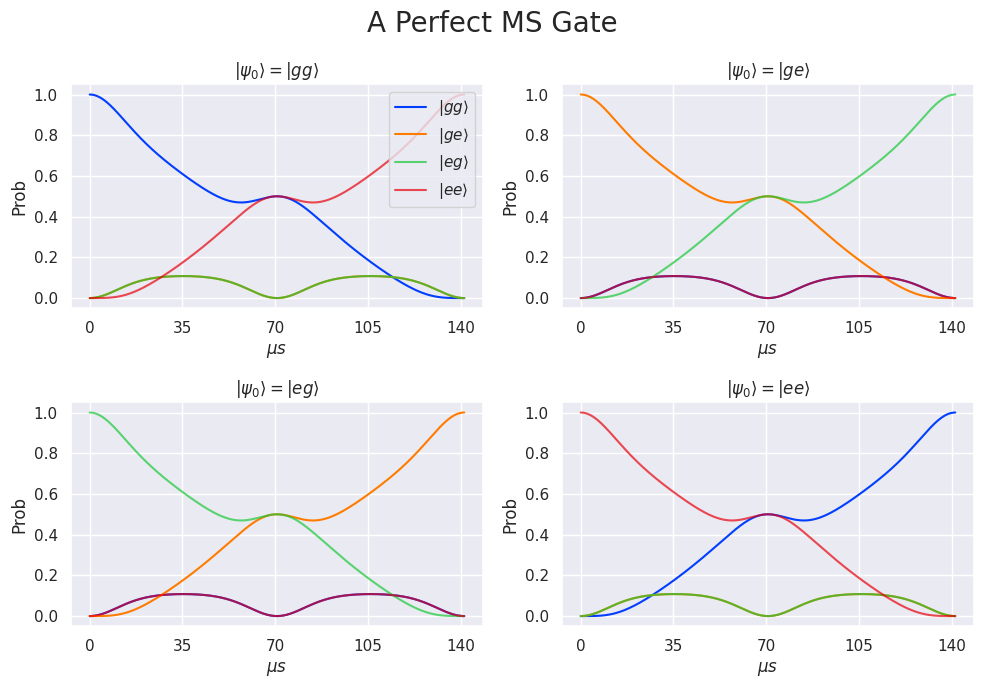

In [3]:
gate_time=4*np.pi/epsilon
tlist=np.linspace(0, gate_time, 1000)

z_basis=[tensor(g,g,qeye(n))*tensor(g.dag(),g.dag(), qeye(n)), tensor(g,e,qeye(n))*tensor(g.dag(),e.dag(), qeye(n)), 
        tensor(e,g,qeye(n))*tensor(e.dag(),g.dag(), qeye(n)), tensor(e,e,qeye(n))*tensor(e.dag(),e.dag(), qeye(n))]
H=H_MS(rabi_0, rabi_0, epsilon, -epsilon)

def plot_evol(H, psi0, title, labels=False, expect=z_basis):
    evol=mesolve(H, psi0, tlist, e_ops=expect)
    plt.plot(tlist, evol.expect[0], label=r'$|gg\rangle$')
    plt.plot(tlist, evol.expect[1], label=r'$|ge\rangle$')
    plt.plot(tlist, evol.expect[2], label=r'$|eg\rangle$', alpha=.7)
    plt.plot(tlist, evol.expect[3], label=r'$|ee\rangle$', alpha=.7)
    plt.xticks(np.arange(0, 1.60e-4, .35e-4), labels=[f'{x}' for x in np.arange(0,160,35)])
    plt.xlabel(r'$\mu s$')
    plt.title(r"$|\psi_0\rangle=$"+title)
    plt.ylabel('Prob')
    if labels: plt.legend(loc='upper right')
def plot_evol_basis(H, suptitle):
    psi0=[gg,ge,eg,ee]
    plt.figure(figsize=(10,7))
    labels=[True, False, False, False]
    for rho0,labels, title,i in zip(psi0, labels, [r'$|gg\rangle$',r'$|ge\rangle$',r'$|eg\rangle$',r'$|ee\rangle$'], list(range(1,5))):
        plt.subplot(2,2, i)
        plot_evol(H,rho0, title, labels)
    plt.suptitle(suptitle, fontsize=20)
    plt.tight_layout()
    plt.show()
plot_evol_basis(H,'A Perfect MS Gate')


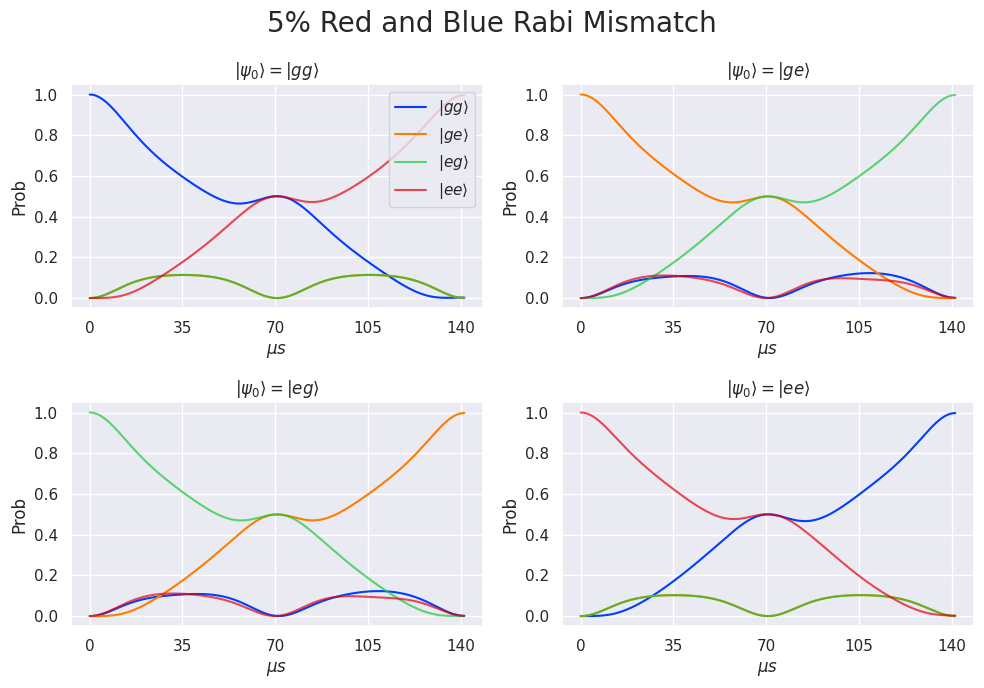

In [4]:


H_rabi=H_MS(rabi_0*.975, rabi_0*1.025    , epsilon, -epsilon)
plot_evol_basis(H_rabi, '5% Red and Blue Rabi Mismatch')

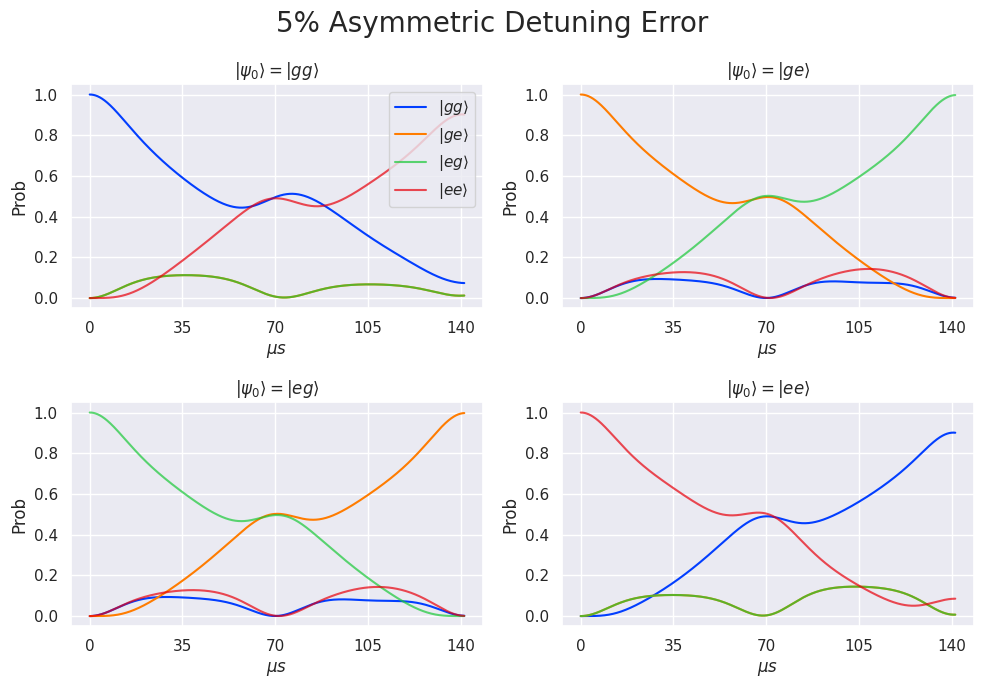

In [5]:
H_asym=H_MS(rabi_0, rabi_0, epsilon*1.05, -epsilon*.95)
plot_evol_basis(H_asym, "5% Asymmetric Detuning Error")

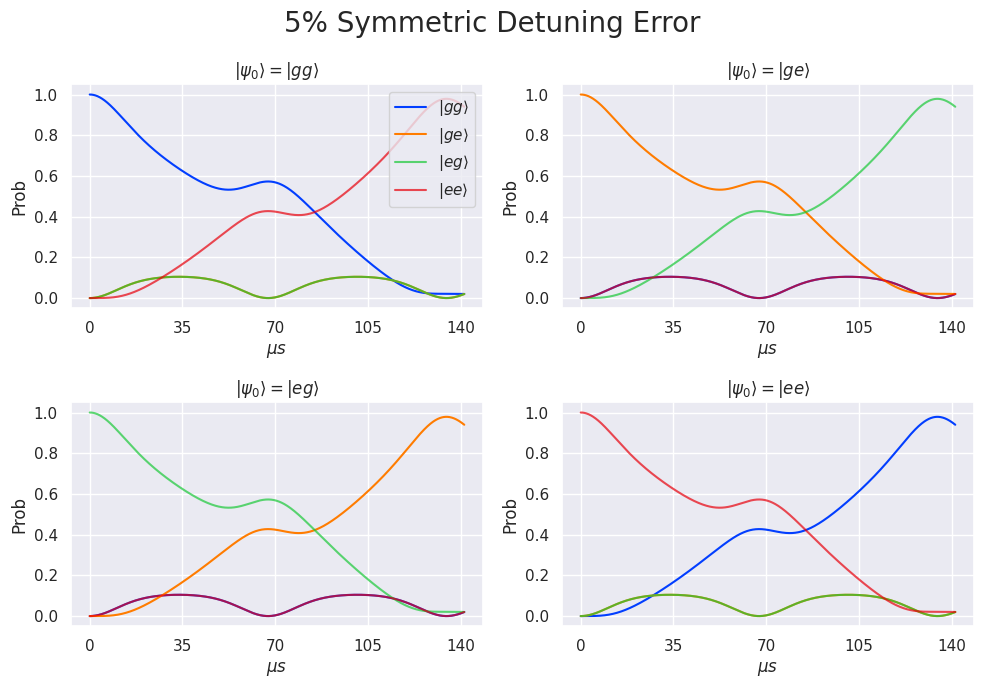

In [6]:
H_sym=H_MS(rabi_0, rabi_0, epsilon*1.05, -epsilon*1.05)
plot_evol_basis(H_sym, "5% Symmetric Detuning Error")

# Analysis
The MS gate appears to be more robust to slight drifts in the Rabi freq (proportional to laser amplitude) than other error sources discussed in this work. But, the drift in trap frequency (symmetric error) appears to be the most destructive to gate fidelity [[0]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.180501). The MS gate is crucial to generating maximally entangled states, and the trap frequency drift is far less robust in this regard than laser frequency or amplitude errors based on the data in this work. Regarding generating maximally entangled states, the MS gate is suprisingly very robust to minor drifts in laser amplitude and frequency, though the laser frequency drifts are slightly less robust than laser amplitude drifts. <br>
Refer to the red and blue sideband hamiltonians, assume $\Omega_r=\Omega_b=\Omega$:
$$H_{BSB}= \frac{i \eta}{2} (\Omega e^{i (-\nu+\delta) t}S_{-}a- \Omega^{*} e^{-i (-\nu+\delta) t}S_{+}a^{\dagger}),$$
$$H_{RSB}= \frac{i \eta}{2} (\Omega e^{i (\nu+\delta) t}S_{-}a^{\dagger} - \Omega^{*} e^{-i (\nu+\delta) t}S_{+}a),$$
with motional mode frequency $\nu$, laser detuning frequency $\delta$ for both ions. consider $\epsilon\equiv \nu + \delta$ and $-\epsilon\equiv -\nu+\delta$ so that 
$$H_{BSB}= \frac{i \eta}{2} (\Omega e^{i \epsilon t}S_{-}a- \Omega^{*} e^{-i \epsilon t}S_{+}a^{\dagger}),$$
$$H_{RSB}= \frac{i \eta}{2} (\Omega e^{i \epsilon t}S_{-}a^{\dagger} - \Omega^{*} e^{-i \epsilon t}S_{+}a).$$
Now consider a slight frequency drift error, $\Delta$, such that 
$$-\epsilon-\Delta=-(\nu+\Delta)+\delta, \epsilon+\Delta=(\nu+\Delta)+\delta;$$
the trap frequency error thus produces a symmetric error. 
$$-\epsilon+\Delta=-\nu+(\delta+\Delta), \epsilon+\Delta=\nu+(\delta+\Delta);$$
the laser detuning error produces an asymmetric error. However, the AC Stark shift (drift in qubit frequency) can also produce an asymmetric error. The laser detuning frequency, $\delta$, can be defined as $\delta=\omega_i+\omega_{01}$ where $\omega_i$ is the ion frequency and 

# The Sidequest: Find Why $\eta$ Has $\frac{1}{\sqrt{2}}$ Factor With a Two Ion Chain
This sidequest is based on Yukai Wu's 2019 doctoral dissertation.

Consider 
$$U=\sum_i(-\frac{1}{2}\alpha_{2} z^{2}_{i} +\frac{1}{4}\alpha_{4} z^4_i)+\sum_{i<j}\frac{1}{4\pi\epsilon_0}\frac{e^2}{\left|
    z_i-z_j\right|}, \ \  (\alpha_2, \alpha_4 >0)$$

# Other Sidequest: Simulating Error 

$$\ket{\phi}=\frac{1}{\sqrt{2}}(\ket{gg}-i\ket{ee}), \ket{\psi}=U_{MS}(\frac{\pi}{4})\ket{gg}$$
$U_{MS}(t)$ is derived from the Magnus expansion of $H_{MS}=H_{BSB}+H_{RSB}$ from earlier. $\ket{\phi}$ is the maximally-entangled state $\ket{\psi}$ when $U_{MS}$ is free of error; $\ket{\phi}=\exp\left(\frac{-i\pi}{4}X\otimes X\right)\ket{gg}$. 
$$\mathcal{F}(\rho, \sigma)\equiv \textrm{Tr}\left(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}}\right)^2,$$
$$\rho= \ket{\psi}\bra{\psi}, \sigma=\ket{\phi}\bra{\phi}$$
The fidelity of density matrices $\rho$ and $\sigma$ will serve as a quality quantum distance metric to help us determine the impact of various errors on the MS gate's fidelity.

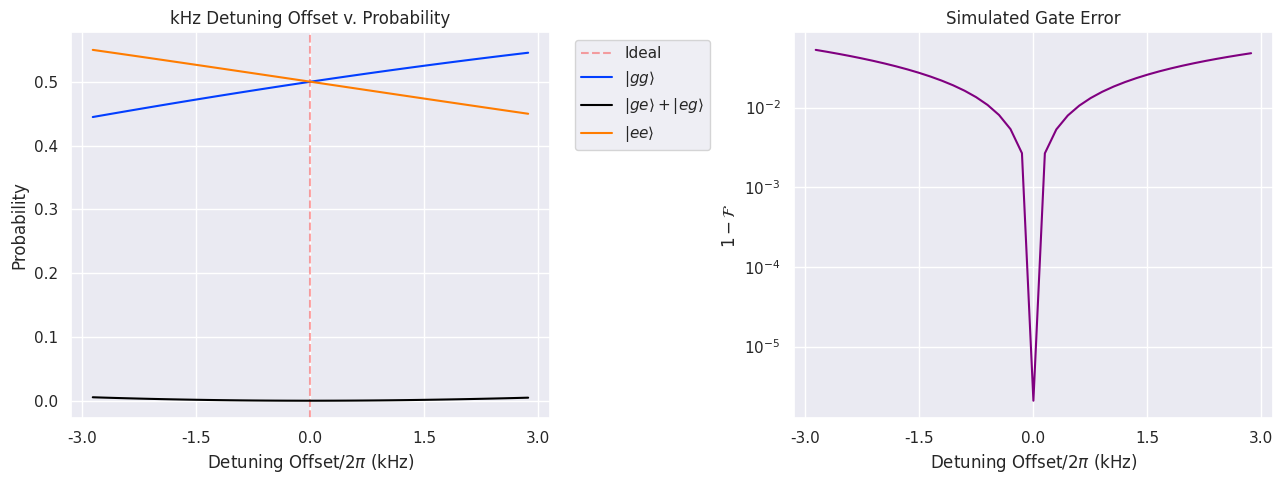

In [7]:
num_int=40 #n-1
gate_time=np.linspace(0,2*np.pi/epsilon,num_int) # 1 gate time
detuning_offset=np.concatenate((np.linspace((-9000/(np.pi)), 0, int(num_int/2)),np.linspace(0, 9000/(np.pi), int(num_int/2))[1:]), None)
res_list=np.empty((3,num_int-1))
for i in range(num_int-1):
    H=H_MS(rabi_0,rabi_0, epsilon+detuning_offset[i], -epsilon-detuning_offset[i])
    res=mesolve(H,gg, gate_time, e_ops=z_basis)
    res_list[0][i]=res.expect[0][-1]
    res_list[1][i]=res.expect[1][-1]+res.expect[2][-1]
    res_list[2][i]=res.expect[3][-1]
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.axvline(label='Ideal', color='red', ls='--', alpha=.35)
plt.plot(detuning_offset,res_list[0], label=r'$|gg\rangle$')
plt.plot(detuning_offset, res_list[1], color='black', label=r'$|ge\rangle + |eg\rangle$')
plt.plot(detuning_offset,res_list[2], label=r'$|ee\rangle$')
plt.xlabel(r'Detuning Offset/$2\pi$ (kHz)')
plt.xticks(np.linspace(-3000, 3000, 5), labels=[f'{x}' for x in np.linspace(-3, 3, 5)])
plt.ylabel('Probability')
plt.title('kHz Detuning Offset v. Probability')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))

plt.subplot(1,2,2)
res_list=np.empty(num_int-1)
max_ent=(1/np.sqrt(2))*(gg-1j*ee)
for i in range(num_int-1):
    H=H_MS(rabi_0,rabi_0, epsilon+detuning_offset[i], -epsilon-detuning_offset[i])
    res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
    res_list[i]=fidelity(res*res.dag(), max_ent*max_ent.dag())
plt.plot(detuning_offset,res_list, color='purple')
plt.yscale('log')
plt.xlabel(r'Detuning Offset/$2\pi$ (kHz)')
plt.xticks(np.linspace(-3000, 3000, 5), labels=[f'{x}' for x in np.linspace(-3, 3, 5)])
plt.ylabel(r'$1-\mathcal{F}$')
plt.title('Simulated Gate Error')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

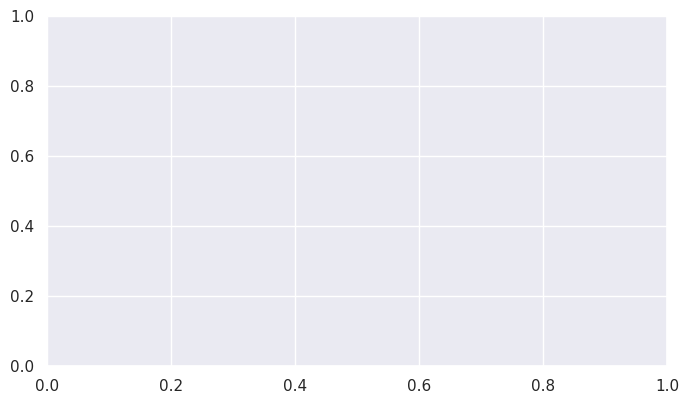

In [14]:
from scipy.interpolate import RegularGridInterpolator
precision=40
num_int=40
method='cubic'
x=np.linspace(0,num_int-1,num_int-1)
y=np.linspace(0,num_int-1,num_int-1)
xt, yt = np.meshgrid(np.linspace(0, num_int-1, (num_int-1)*precision), np.linspace(0, num_int-1, (num_int-1)*precision), indexing='ij')
interp=np.array([xt.ravel(), yt.ravel()]).T
X,Y=np.meshgrid(x,y, indexing='ij')
max_ent=(1/np.sqrt(2))*(gg-1j*ee)
detuning_offset=np.concatenate((np.linspace(-100, 0, int(num_int/2)),np.linspace(0, 100, int(num_int/2))[1:]), None)
rabi_det=np.concatenate((np.linspace(-100, 0, int(num_int/2)),np.linspace(0, 100, int(num_int/2))[1:]), None)
res_list_sym=np.empty((num_int-1,num_int-1))
for j in range(num_int-1):
    for k in range(num_int-1):
        H=H_MS(rabi_0+rabi_det[k],rabi_0-rabi_det[k], epsilon+detuning_offset[j], -epsilon-detuning_offset[j])
        res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
        res_list_sym[k][j]=np.log10(fidelity(res*res.dag(), max_ent*max_ent.dag()))
fig=plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
f=RegularGridInterpolator([x,y], res_list_sym)
heatmap=f(interp, method=method).reshape((num_int-1)*precision,(num_int-1)*precision)
c=plt.pcolormesh(heatmap, cmap='viridis', vmin=res_list_sym.min(), vmax=res_list_sym.max())
plt.xticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-100, 100, 5)])
plt.yticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-100, 100, 5)])
plt.contour(heatmap, levels=[-10e6,-5], colors='black', linestyles='dashed', alpha=.6)
plt.contour(heatmap, levels=[-4, -3], colors='black', linestyles='solid', alpha=.60)
plt.contour(heatmap, levels=[-2,-1], colors='black', linestyles='solid', alpha=.60)
plt.ylabel('Rabi Mismatch (Hz)')
plt.xlabel('Symmetric Detuning Offset (Hz)')
plt.colorbar(c, label=r'$\log_{10}\left(1-\mathcal{F}\right)$',)
#plt.ylabel(r'$1-\mathcal{F}$')

res_list_asym=np.empty((num_int-1,num_int-1))
for j in range(num_int-1):
    for k in range(num_int-1):
        H=H_MS(rabi_0+rabi_det[k],rabi_0-rabi_det[k], epsilon+detuning_offset[j], -epsilon+detuning_offset[j])
        res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
        res_list_asym[k][j]=np.log10(fidelity(res*res.dag(), max_ent*max_ent.dag()))

plt.subplot(2,1,2)
f=RegularGridInterpolator([x,y], res_list_asym)
heatmap=f(interp, method=method).reshape((num_int-1)*precision,(num_int-1)*precision)
c=plt.pcolormesh(heatmap, cmap='viridis')
plt.contour(heatmap, levels=[-10e6,-5], colors='black', linestyles='dashed', alpha=.6)
plt.contour(heatmap, levels=[-4, -3], colors='black', linestyles='solid', alpha=.60)
plt.contour(heatmap, levels=[-2,-1], colors='black', linestyles='solid', alpha=.60)
plt.xlabel('Asymmetric Detuning Offset (Hz)')
plt.ylabel('Rabi Mismatch (Hz)')
plt.xticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-100, 100, 5)])
plt.yticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-100, 100, 5)])
plt.colorbar(c, label=r'$\log_{10}\left(1-\mathcal{F}\right)$',)


#plt.ylabel(r'$1-\mathcal{F}$')
plt.suptitle('Simulated Error Landscape')
plt.tight_layout()
plt.show()

In [ ]:
Dashed 

It appears as though the asymmetric detuning has a moment where its fidelity is good even in the prescence of Rabi mismatches...almost as if it can be calibrated.

In [25]:
fig=plt.figure(figsize=(9,7))
num_int, precision =40,40
x=np.linspace(0,num_int-1,num_int-1)
y=np.linspace(0,num_int-1,num_int-1)
xt, yt = np.meshgrid(np.linspace(0, num_int-1, (num_int-1)*precision), np.linspace(0, num_int-1, (num_int-1)*precision), indexing='ij')
interp=np.array([xt.ravel(), yt.ravel()]).T
X,Y=np.meshgrid(x,y, indexing='ij')
detuning_offset=np.concatenate((np.linspace((-9000/(np.pi)), 0, int(num_int/2)),np.linspace(0, 9000/(np.pi), int(num_int/2))[1:]), None)
rabi_det=np.concatenate((np.linspace((-9000/(np.pi)), 0, int(num_int/2)),np.linspace(0, 9000/(np.pi), int(num_int/2))[1:]), None)
res_list_asym=np.empty((num_int-1,num_int-1))
for j in range(num_int-1):
    for k in range(num_int-1):
        H=H_MS(rabi_0+rabi_det[k],rabi_0-rabi_det[k], epsilon+detuning_offset[j], -epsilon+detuning_offset[j])
        res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
        res_list_asym[k][j]=np.log10(fidelity(res*res.dag(), max_ent*max_ent.dag()))

f=RegularGridInterpolator([x,y], res_list_asym)
heatmap=f(interp, method=method).reshape((num_int-1)*precision,(num_int-1)*precision)
c=plt.pcolormesh(heatmap, cmap='viridis')
plt.contour(heatmap, levels=[-10e6,-3], colors='black', linestyles='dashed', alpha=.6)
plt.contour(heatmap, levels=[-2, -1], colors='black', linestyles='solid', alpha=.60)
plt.contour(heatmap, levels=[0,], colors='black', linestyles='solid', alpha=.60)
plt.xlabel(r'Asymmetric Detuning Offset/$2\pi$ (kHz)')
plt.ylabel(r'Rabi Mismatch/$2\pi$ (kHz)')
plt.xticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-3, 3, 5)])
plt.yticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-3, 3, 5)])
plt.colorbar(c, label=r'$\log_{10}\left(1-\mathcal{F}\right)$',)


#plt.ylabel(r'$1-\mathcal{F}$')
plt.suptitle('Simulated Error Landscape of Extreme Detuning Error v. Rabi Mismatch')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

<Figure size 900x700 with 0 Axes>

Dashed contour lines where $1-\mathcal{F}<10^{-3}$. Even with extreme Rabi mismatches, we can still calibrate the MS gate to get 3 9's of fidelity!

# Further Progressions on This Topic
- Simulate calibration of MS gate with frequency modulation for robust gates.
- Simulate MS gates with larger ion chains.
- Simulate gate error models with other major error sources, such as heating errors and crosstalk between motional modes.
- Efficiently simulate the MS (with tensor networks?)

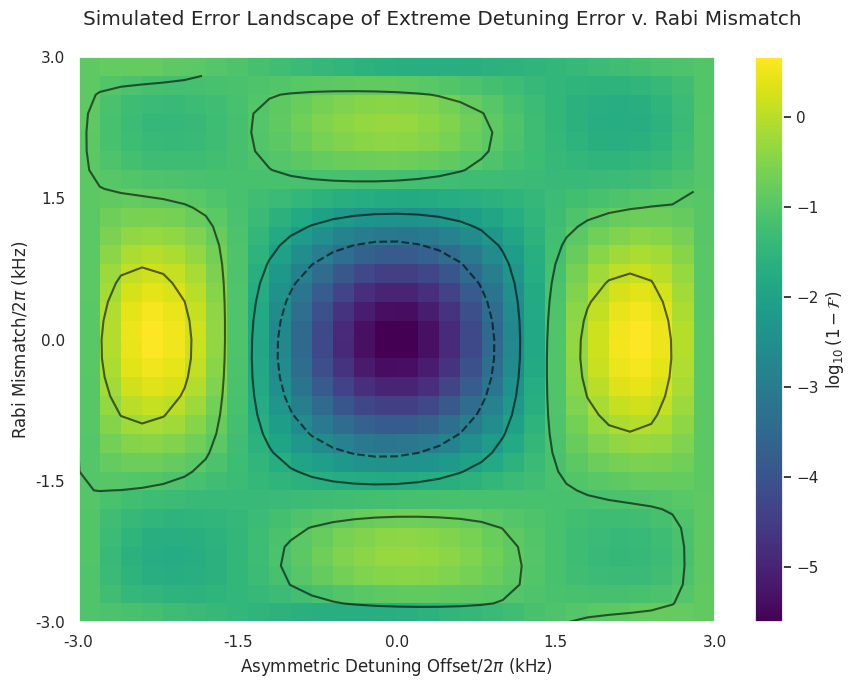

In [34]:
fig=plt.figure(figsize=(9,7))
num_int, precision =6,6
x=np.linspace(0,num_int-1,num_int-1)
y=np.linspace(0,num_int-1,num_int-1)
xt, yt = np.meshgrid(np.linspace(0, num_int-1, (num_int-1)*precision), np.linspace(0, num_int-1, (num_int-1)*precision), indexing='ij')
interp=np.array([xt.ravel(), yt.ravel()]).T
X,Y=np.meshgrid(x,y, indexing='ij')
detuning_offset=np.concatenate((np.linspace((-9000/(np.pi)), 0, int(num_int/2)),np.linspace(0, 9000/(np.pi), int(num_int/2))[1:]), None)
rabi_det=np.concatenate((np.linspace(-epsilon/(2*np.pi), 0, int(num_int/2)),np.linspace(0, epsilon/(2*np.pi), int(num_int/2))[1:]), None)
res_list_asym=np.empty((num_int-1,num_int-1))

def vf(rabi_det, detuning_offset):
    H=H_MS(rabi_0+rabi_det,rabi_0-rabi_det, epsilon+detuning_offset, -epsilon+detuning_offset)
    res=sesolve(H,gg, gate_time, e_ops=[]).states[-1] #Leaving expectation operator empty returns list of statevectors for times
    return np.log10(fidelity(res*res.dag(), max_ent*max_ent.dag()))
vf=np.vectorize(vf)
rabi_det_t=rabi_det.reshape(rabi_det.shape[0],1)
detuning_offset_p=detuning_offset.reshape(1, detuning_offset.shape[0])
res_list_asym=vf(rabi_det_t,detuning_offset_p)
f=RegularGridInterpolator([x,y], res_list_asym)
heatmap=f(interp, method=method).reshape((num_int-1)*precision,(num_int-1)*precision)
c=plt.pcolormesh(heatmap, cmap='viridis')
plt.contour(heatmap, levels=[-10e6,-3], colors='black', linestyles='dashed', alpha=.6)
plt.contour(heatmap, levels=[-2, -1], colors='black', linestyles='solid', alpha=.60)
plt.contour(heatmap, levels=[0,], colors='black', linestyles='solid', alpha=.60)
plt.xlabel(r'Asymmetric Detuning Offset/$2\pi$ (kHz)')
plt.ylabel(r'Rabi Mismatch/$2\pi$ (kHz)')
plt.xticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-3, 3, 5)])
plt.yticks(np.linspace(0, (num_int-1)*precision, 5), labels=[f'{x:.4}' for x in np.linspace(-3, 3, 5)])
plt.colorbar(c, label=r'$\log_{10}\left(1-\mathcal{F}\right)$',)


#plt.ylabel(r'$1-\mathcal{F}$')
plt.suptitle('Simulated Error Landscape of Extreme Detuning Error v. Rabi Mismatch')
plt.tight_layout()
plt.show()

In [32]:
detuning_offset.reshape(1, detuning_offset.shape[0])

array([[-2864.78897565, -2714.01060851, -2563.23224137, -2412.45387424,
        -2261.6755071 , -2110.89713996, -1960.11877282, -1809.34040568,
        -1658.56203854, -1507.7836714 , -1357.00530426, -1206.22693712,
        -1055.44856998,  -904.67020284,  -753.8918357 ,  -603.11346856,
         -452.33510142,  -301.55673428,  -150.77836714,     0.        ,
          150.77836714,   301.55673428,   452.33510142,   603.11346856,
          753.8918357 ,   904.67020284,  1055.44856998,  1206.22693712,
         1357.00530426,  1507.7836714 ,  1658.56203854,  1809.34040568,
         1960.11877282,  2110.89713996,  2261.6755071 ,  2412.45387424,
         2563.23224137,  2714.01060851,  2864.78897565]])